In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
df = pd.read_csv('output/summarry_biceps_curl.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (3135, 138)
Columns: ['video_id', 'rep_id', 'frame_id', 'lm_0_x', 'lm_0_y', 'lm_0_z', 'lm_0_vis', 'lm_1_x', 'lm_1_y', 'lm_1_z', 'lm_1_vis', 'lm_2_x', 'lm_2_y', 'lm_2_z', 'lm_2_vis', 'lm_3_x', 'lm_3_y', 'lm_3_z', 'lm_3_vis', 'lm_4_x', 'lm_4_y', 'lm_4_z', 'lm_4_vis', 'lm_5_x', 'lm_5_y', 'lm_5_z', 'lm_5_vis', 'lm_6_x', 'lm_6_y', 'lm_6_z', 'lm_6_vis', 'lm_7_x', 'lm_7_y', 'lm_7_z', 'lm_7_vis', 'lm_8_x', 'lm_8_y', 'lm_8_z', 'lm_8_vis', 'lm_9_x', 'lm_9_y', 'lm_9_z', 'lm_9_vis', 'lm_10_x', 'lm_10_y', 'lm_10_z', 'lm_10_vis', 'lm_11_x', 'lm_11_y', 'lm_11_z', 'lm_11_vis', 'lm_12_x', 'lm_12_y', 'lm_12_z', 'lm_12_vis', 'lm_13_x', 'lm_13_y', 'lm_13_z', 'lm_13_vis', 'lm_14_x', 'lm_14_y', 'lm_14_z', 'lm_14_vis', 'lm_15_x', 'lm_15_y', 'lm_15_z', 'lm_15_vis', 'lm_16_x', 'lm_16_y', 'lm_16_z', 'lm_16_vis', 'lm_17_x', 'lm_17_y', 'lm_17_z', 'lm_17_vis', 'lm_18_x', 'lm_18_y', 'lm_18_z', 'lm_18_vis', 'lm_19_x', 'lm_19_y', 'lm_19_z', 'lm_19_vis', 'lm_20_x', 'lm_20_y', 'lm_20_z', 'lm_20_vis', 'lm

,video_id,rep_id,frame_id,lm_0_x,lm_0_y,lm_0_z,lm_0_vis,lm_1_x,lm_1_y,lm_1_z,...,lm_31_y,lm_31_z,lm_31_vis,lm_32_x,lm_32_y,lm_32_z,lm_32_vis,label_back,label_elbow,label_flare
0,01502df8-593c-42d0-86ae-7cbd48d8741a,1,35,0.483223,0.170639,-0.055122,0.998547,0.491386,0.156659,-0.073906,...,0.924898,-0.376060,0.983876,0.494905,0.822694,0.473240,0.569445,0,0,0
1,01502df8-593c-42d0-86ae-7cbd48d8741a,1,36,0.481026,0.170386,-0.056209,0.998681,0.489419,0.156550,-0.075012,...,0.925647,-0.353399,0.983541,0.495075,0.804442,0.474874,0.557250,0,0,0
2,01502df8-593c-42d0-86ae-7cbd48d8741a,1,37,0.479034,0.170274,-0.056601,0.998789,0.487178,0.156233,-0.075076,...,0.926066,-0.349490,0.983468,0.494276,0.820685,0.416490,0.558365,0,0,0
3,01502df8-593c-42d0-86ae-7cbd48d8741a,1,38,0.479740,0.177363,-0.057385,0.998750,0.486515,0.160765,-0.075857,...,0.926393,-0.252694,0.982678,0.485917,0.865583,0.256504,0.566924,0,0,0
4,01502df8-593c-42d0-86ae-7cbd48d8741a,1,39,0.479656,0.188291,-0.033205,0.998812,0.484254,0.169241,-0.052964,...,0.926534,-0.266953,0.982584,0.477057,0.872099,0.260511,0.579873,0,0,0


In [10]:
# 2. Chuẩn bị dữ liệu - PER-FRAME (không dùng sequences)

# Xác định các cột Feature (132 features: 33 landmarks x 4 giá trị)
feature_cols = []
for i in range(33):
    feature_cols.extend([f'lm_{i}_x', f'lm_{i}_y', f'lm_{i}_z', f'lm_{i}_vis'])

# Xác định các cột Label (Multi-label classification)
label_cols = ['label_back', 'label_elbow', 'label_flare']

# Trích xuất X (features) và y (labels) cho từng frame
X = df[feature_cols].values
y = df[label_cols].values

print(f"X shape: {X.shape}")  # (số_frames, 132)
print(f"y shape: {y.shape}")  # (số_frames, 3)

# Chia tập train/test theo video_id để tránh data leakage
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df['video_id']))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Video train: {df.iloc[train_idx]['video_id'].nunique()}")
print(f"Video test: {df.iloc[test_idx]['video_id'].nunique()}")

X shape: (3135, 132)
y shape: (3135, 3)

Train set: (2451, 132)
Test set: (684, 132)
Video train: 43
Video test: 11


In [11]:
# 3. Định nghĩa các mô hình và Grid Search Parameters

# Logistic Regression
lr_params = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__solver': ['lbfgs', 'liblinear'],
    'estimator__max_iter': [200, 500, 1000]
}

# Random Forest
rf_params = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# XGBoost
xgb_params = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7, 10],
    'estimator__learning_rate': [0.01, 0.1, 0.3],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

models_config = {
    'Logistic Regression': {
        'model': MultiOutputClassifier(LogisticRegression(random_state=42)),
        'params': lr_params
    },
    'Random Forest': {
        'model': MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1)),
        'params': rf_params
    },
    'XGBoost': {
        'model': MultiOutputClassifier(XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)),
        'params': xgb_params
    }
}

print("Cấu hình mô hình đã sẵn sàng!")
print(f"Số mô hình: {len(models_config)}")

Cấu hình mô hình đã sẵn sàng!
Số mô hình: 3


=== Phân tích phân phối Labels ===

Train set:
  label_back:
    Class 0 (Correct): 1410 (57.53%)
    Class 1 (Error): 1041 (42.47%)
  label_elbow:
    Class 0 (Correct): 2437 (99.43%)
    Class 1 (Error): 14 (0.57%)
  label_flare:
    Class 0 (Correct): 2445 (99.76%)
    Class 1 (Error): 6 (0.24%)

Test set:
  label_back:
    Class 0 (Correct): 291 (42.54%)
    Class 1 (Error): 393 (57.46%)
  label_elbow:
    Class 0 (Correct): 649 (94.88%)
    Class 1 (Error): 35 (5.12%)
  label_flare:
    Class 0 (Correct): 684 (100.00%)


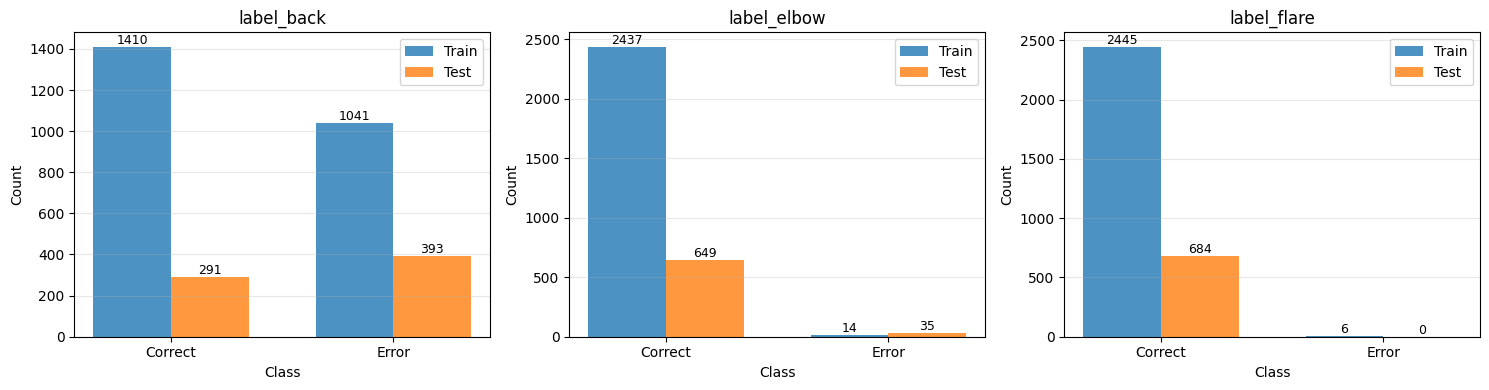


⚠️  Lưu ý: Nếu một label có quá ít samples của 1 class (< 5%), có thể gây ra:
   - CV Score = NaN (không đủ samples trong 1 fold)
   - F1-Score thấp hoặc NaN
   - Model không học được class hiếm



In [12]:
# 3.1. Phân tích phân phối labels (để hiểu vấn đề CV score)

print("=== Phân tích phân phối Labels ===\n")

print("Train set:")
for i, label in enumerate(label_cols):
    unique, counts = np.unique(y_train[:, i], return_counts=True)
    print(f"  {label}:")
    for val, count in zip(unique, counts):
        print(f"    Class {val} ({'Correct' if val == 0 else 'Error'}): {count} ({count/len(y_train)*100:.2f}%)")

print("\nTest set:")
for i, label in enumerate(label_cols):
    unique, counts = np.unique(y_test[:, i], return_counts=True)
    print(f"  {label}:")
    for val, count in zip(unique, counts):
        print(f"    Class {val} ({'Correct' if val == 0 else 'Error'}): {count} ({count/len(y_test)*100:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, label in enumerate(label_cols):
    ax = axes[i]
    
    train_counts = np.bincount(y_train[:, i].astype(int), minlength=2)
    test_counts = np.bincount(y_test[:, i].astype(int), minlength=2)
    
    x = np.arange(2)
    width = 0.35
    
    ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
    ax.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{label}')
    ax.set_xticks(x)
    ax.set_xticklabels(['Correct', 'Error'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm giá trị
    for j, (train_c, test_c) in enumerate(zip(train_counts, test_counts)):
        ax.text(j - width/2, train_c, str(train_c), ha='center', va='bottom', fontsize=9)
        ax.text(j + width/2, test_c, str(test_c), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n⚠️  Lưu ý: Nếu một label có quá ít samples của 1 class (< 5%), có thể gây ra:")
print("   - CV Score = NaN (không đủ samples trong 1 fold)")
print("   - F1-Score thấp hoặc NaN")
print("   - Model không học được class hiếm\n")

In [13]:
# 4. Huấn luyện và tối ưu hóa các mô hình bằng GridSearchCV

from sklearn.metrics import make_scorer, hamming_loss

# Custom scorer cho multi-label classification
def multi_label_f1_score(y_true, y_pred):
    """
    Tính F1-score trung bình cho multi-label classification
    Xử lý trường hợp có label chỉ có 1 class
    """
    f1_scores = []
    for i in range(y_true.shape[1]):
        # Kiểm tra nếu chỉ có 1 class trong y_true
        if len(np.unique(y_true[:, i])) == 1:
            # Nếu dự đoán đúng 100% thì f1=1, sai thì f1=0
            if np.array_equal(y_true[:, i], y_pred[:, i]):
                f1_scores.append(1.0)
            else:
                f1_scores.append(0.0)
        else:
            # Tính F1 bình thường
            f1 = f1_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0)
            f1_scores.append(f1)
    return np.mean(f1_scores)

# Tạo custom scorer
custom_scorer = make_scorer(multi_label_f1_score, greater_is_better=True)

results = {}
best_models = {}

for model_name, config in models_config.items():
    print(f"\n{'='*60}")
    print(f"Đang train: {model_name}")
    print(f"{'='*60}")
    
    # Khởi tạo GridSearchCV với custom scorer
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # Tăng lên 5-fold để có nhiều dữ liệu hơn mỗi fold
        scoring=custom_scorer,  # Dùng custom scorer
        n_jobs=-1,
        verbose=2,
        return_train_score=True,
        error_score=0.0  # Nếu có lỗi thì cho score = 0 thay vì raise
    )
    
    # Fit model
    print(f"\nBắt đầu GridSearchCV cho {model_name}...")
    try:
        grid_search.fit(X_train_scaled, y_train)
        
        # Kiểm tra nếu best_score_ là NaN
        if np.isnan(grid_search.best_score_):
            print(f"\n⚠️  WARNING: CV Score là NaN cho {model_name}")
            print("   Có thể do dữ liệu không cân bằng hoặc quá ít samples")
            # Tiếp tục nhưng lưu ý
        
        # Lưu best model
        best_models[model_name] = grid_search.best_estimator_
        
        # Dự đoán trên tập test
        y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        
        # Tính toán metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        # Tính F1-score cho từng label rồi lấy trung bình
        f1_per_label = []
        for i in range(y_test.shape[1]):
            # Kiểm tra số lượng classes
            unique_classes = len(np.unique(y_test[:, i]))
            if unique_classes == 1:
                # Chỉ có 1 class
                if np.array_equal(y_test[:, i], y_pred[:, i]):
                    f1_per_label.append(1.0)
                else:
                    f1_per_label.append(0.0)
            else:
                f1 = f1_score(y_test[:, i], y_pred[:, i], average='weighted', zero_division=0)
                f1_per_label.append(f1)
        
        f1_weighted = np.mean(f1_per_label)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        
        # Hamming Loss (tỷ lệ labels bị dự đoán sai)
        h_loss = hamming_loss(y_test, y_pred)
        
        # Lưu kết quả
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'test_accuracy': accuracy,
            'test_f1_weighted': f1_weighted,
            'test_f1_macro': f1_macro,
            'test_f1_micro': f1_micro,
            'test_hamming_loss': h_loss,
            'y_pred': y_pred,
            'f1_per_label': f1_per_label  # Lưu F1 cho từng label
        }
        
        print(f"\n{model_name} - Kết quả:")
        print(f"  Best CV Score: {grid_search.best_score_:.4f}")
        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  Test F1 (weighted): {f1_weighted:.4f}")
        print(f"  Test F1 (macro): {f1_macro:.4f}")
        print(f"  Test Hamming Loss: {h_loss:.4f}")
        print(f"  F1 per label: {[f'{f:.4f}' for f in f1_per_label]}")
        print(f"  Best Params: {grid_search.best_params_}")
        
    except Exception as e:
        print(f"\n❌ Lỗi khi train {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*60}")
print("Hoàn thành việc huấn luyện tất cả các mô hình!")
print(f"{'='*60}")


Đang train: Logistic Regression

Bắt đầu GridSearchCV cho Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Logistic Regression - Kết quả:
  Best CV Score: 0.5710
  Test Accuracy: 0.7412
  Test F1 (weighted): 0.8897
  Test F1 (macro): 0.2772
  Test Hamming Loss: 0.1048
  F1 per label: ['0.7451', '0.9240', '1.0000']
  Best Params: {'estimator__C': 10, 'estimator__max_iter': 200, 'estimator__solver': 'liblinear'}

Đang train: Random Forest

Bắt đầu GridSearchCV cho Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Logistic Regression - Kết quả:
  Best CV Score: 0.5710
  Test Accuracy: 0.7412
  Test F1 (weighted): 0.8897
  Test F1 (macro): 0.2772
  Test Hamming Loss: 0.1048
  F1 per label: ['0.7451', '0.9240', '1.0000']
  Best Params: {'estimator__C': 10, 'estimator__max_iter': 200, 'estimator__solver': 'liblinear'}

Đang train: Random Forest

Bắt đầu GridSearchCV cho Random Forest...
Fitting 5 folds for each of 108 candi


=== So sánh các mô hình ===
              Model  CV Score  Test Accuracy  Test F1 (weighted)  Test F1 (macro)  Test F1 (micro)
      Random Forest  0.922165       0.764620            0.913573         0.276730         0.792793
Logistic Regression  0.570983       0.741228            0.889703         0.277164         0.701803
            XGBoost  0.560744       0.653509            0.864767         0.218444         0.621701

✓ Đã lưu bảng so sánh vào 'output/bicep_curl_models_comparison.csv'

🏆 Mô hình tốt nhất: Random Forest
   F1-Score (weighted): 0.9136


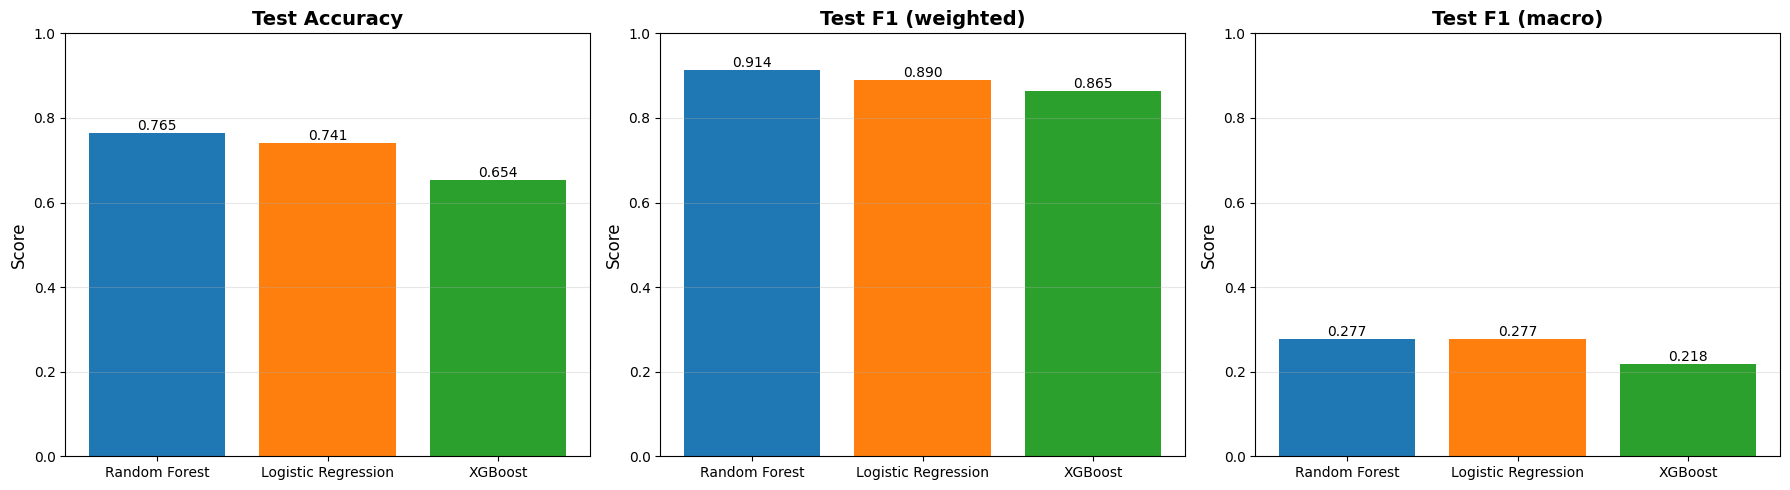


✓ Đã lưu biểu đồ so sánh vào 'output/bicep_curl_models_comparison.png'


In [14]:
# 5. So sánh và lựa chọn mô hình tốt nhất

# Tạo DataFrame để so sánh
comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'CV Score': result['best_cv_score'],
        'Test Accuracy': result['test_accuracy'],
        'Test F1 (weighted)': result['test_f1_weighted'],
        'Test F1 (macro)': result['test_f1_macro'],
        'Test F1 (micro)': result['test_f1_micro']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1 (weighted)', ascending=False)
print("\n=== So sánh các mô hình ===")
print(comparison_df.to_string(index=False))

# Lưu bảng so sánh
comparison_df.to_csv('output/bicep_curl_models_comparison.csv', index=False)
print("\n✓ Đã lưu bảng so sánh vào 'output/bicep_curl_models_comparison.csv'")

# Chọn mô hình tốt nhất
best_model_name = comparison_df.iloc[0]['Model']
best_model = best_models[best_model_name]
print(f"\n🏆 Mô hình tốt nhất: {best_model_name}")
print(f"   F1-Score (weighted): {comparison_df.iloc[0]['Test F1 (weighted)']:.4f}")

# Visualization - So sánh các metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Test Accuracy', 'Test F1 (weighted)', 'Test F1 (macro)']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm giá trị trên cột
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('output/bicep_curl_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu biểu đồ so sánh vào 'output/bicep_curl_models_comparison.png'")


Đánh giá chi tiết: Random Forest

=== Classification Report cho từng label ===


Label: label_back
--------------------------------------------------
              precision    recall  f1-score   support

     Correct       0.75      0.86      0.80       291
       Error       0.88      0.78      0.83       393

    accuracy                           0.82       684
   macro avg       0.81      0.82      0.81       684
weighted avg       0.82      0.82      0.82       684


Label: label_elbow
--------------------------------------------------
              precision    recall  f1-score   support

     Correct       0.95      1.00      0.97       649
       Error       0.00      0.00      0.00        35

    accuracy                           0.95       684
   macro avg       0.47      0.50      0.49       684
weighted avg       0.90      0.95      0.92       684


Label: label_flare
--------------------------------------------------
⚠️  Chỉ có 1 class trong test set: Correct
   Accurac

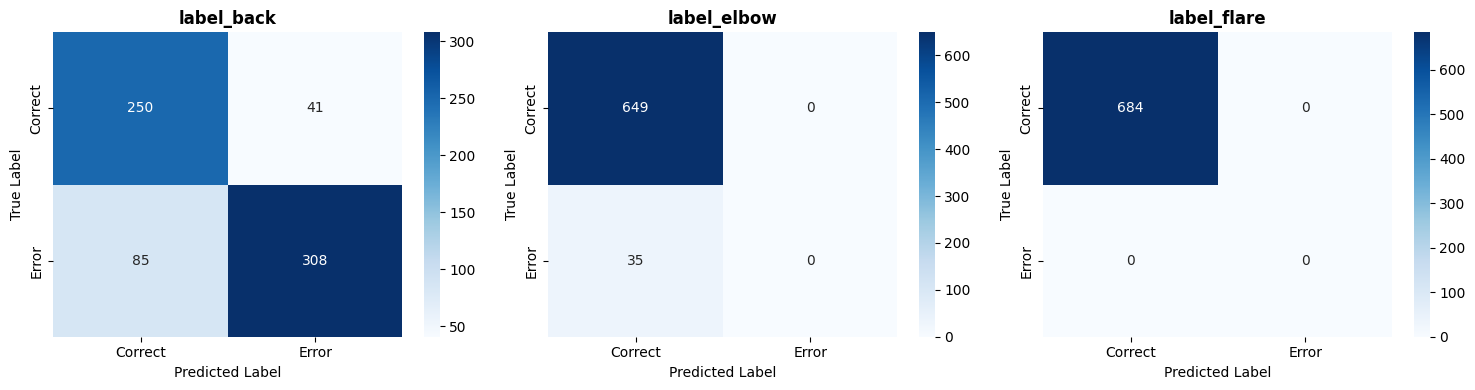


✓ Đã lưu confusion matrices vào 'output/bicep_curl_confusion_matrices.png'

✓ Đã lưu mô hình tốt nhất vào 'output/bicep_curl_best_model.joblib'
✓ Đã lưu scaler vào 'output/bicep_curl_scaler.joblib'
✓ Đã lưu thông tin mô hình vào 'output/bicep_curl_model_info.txt'


In [15]:
# 6. Đánh giá chi tiết mô hình tốt nhất

print(f"\n{'='*60}")
print(f"Đánh giá chi tiết: {best_model_name}")
print(f"{'='*60}\n")

y_pred_best = results[best_model_name]['y_pred']

# Classification Report cho từng label
print("=== Classification Report cho từng label ===\n")
for i, label in enumerate(label_cols):
    print(f"\nLabel: {label}")
    print("-" * 50)
    
    # Kiểm tra số lượng classes thực tế
    unique_true = np.unique(y_test[:, i])
    unique_pred = np.unique(y_pred_best[:, i])
    unique_all = np.unique(np.concatenate([unique_true, unique_pred]))
    
    if len(unique_all) == 1:
        # Chỉ có 1 class duy nhất
        print(f"⚠️  Chỉ có 1 class trong test set: {'Correct' if unique_all[0] == 0 else 'Error'}")
        print(f"   Accuracy: {accuracy_score(y_test[:, i], y_pred_best[:, i]):.4f}")
    else:
        # Có 2 classes - in report bình thường nhưng không chỉ định target_names
        # để sklearn tự động xử lý
        print(classification_report(y_test[:, i], y_pred_best[:, i], 
                                    labels=[0, 1],
                                    target_names=['Correct', 'Error'],
                                    zero_division=0))

# Confusion Matrix cho từng label
print("\n\n=== Confusion Matrix cho từng label ===")
matrices = multilabel_confusion_matrix(y_test, y_pred_best)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (matrix, label) in enumerate(zip(matrices, label_cols)):
    ax = axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Correct', 'Error'],
                yticklabels=['Correct', 'Error'])
    ax.set_title(f'{label}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('output/bicep_curl_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu confusion matrices vào 'output/bicep_curl_confusion_matrices.png'")

# Lưu mô hình tốt nhất
joblib.dump(best_model, 'output/bicep_curl_best_model.joblib')
joblib.dump(scaler, 'output/bicep_curl_scaler.joblib')
print(f"\n✓ Đã lưu mô hình tốt nhất vào 'output/bicep_curl_best_model.joblib'")
print(f"✓ Đã lưu scaler vào 'output/bicep_curl_scaler.joblib'")

# Lưu thông tin mô hình
with open('output/bicep_curl_model_info.txt', 'w', encoding='utf-8') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Best Parameters: {results[best_model_name]['best_params']}\n\n")
    f.write(f"Performance Metrics:\n")
    f.write(f"  - CV Score: {results[best_model_name]['best_cv_score']:.4f}\n")
    f.write(f"  - Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}\n")
    f.write(f"  - Test F1 (weighted): {results[best_model_name]['test_f1_weighted']:.4f}\n")
    f.write(f"  - Test F1 (macro): {results[best_model_name]['test_f1_macro']:.4f}\n")
    f.write(f"  - Test F1 (micro): {results[best_model_name]['test_f1_micro']:.4f}\n")
    f.write(f"  - Test Hamming Loss: {results[best_model_name]['test_hamming_loss']:.4f}\n\n")
    f.write(f"Feature Columns: {len(feature_cols)} features\n")
    f.write(f"Label Columns: {label_cols}\n")
    f.write(f"Training samples: {len(X_train_scaled)}\n")
    f.write(f"Test samples: {len(X_test_scaled)}\n")

print("✓ Đã lưu thông tin mô hình vào 'output/bicep_curl_model_info.txt'")

In [16]:
# 7. Inference - Dự đoán trên video (Per-frame prediction)

import cv2
import mediapipe as mp

# Khởi tạo MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks_from_frame(results):
    """
    Trích xuất 132 features từ 1 frame (33 landmarks x 4 giá trị)
    """
    if not results.pose_landmarks:
        return np.zeros(132)  # Trả về vector 0 nếu không phát hiện pose
        
    row = []
    for landmark in results.pose_landmarks.landmark:
        row.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
    return np.array(row)

def predict_video_per_frame(video_path, model, scaler, threshold=0.5, output_path='output_demo.mp4'):
    """
    Dự đoán từng frame riêng lẻ (không cần chuỗi/sequence)
    
    Args:
        video_path: Đường dẫn video đầu vào
        model: Mô hình đã train
        scaler: StandardScaler đã fit
        threshold: Ngưỡng xác suất để coi là lỗi (0-1)
        output_path: Đường dẫn video đầu ra
    """
    cap = cv2.VideoCapture(video_path)
    
    # Setup output video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    label_names = ['Back Error', 'Elbow Error', 'Flare Error']
    frame_count = 0
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            
            # MediaPipe xử lý
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            
            # Vẽ skeleton lên frame
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
            )
            
            # Dự đoán cho frame hiện tại
            current_errors = []
            if results.pose_landmarks:
                # Trích xuất features
                landmarks = extract_landmarks_from_frame(results)
                
                # Chuẩn hóa
                landmarks_scaled = scaler.transform(landmarks.reshape(1, -1))
                
                # Dự đoán
                prediction = model.predict_proba(landmarks_scaled)
                
                # Xử lý kết quả dự đoán
                # prediction là list of arrays (1 array cho mỗi label)
                for idx, label_name in enumerate(label_names):
                    # Lấy xác suất của class 1 (Error)
                    prob_error = prediction[idx][0][1] if len(prediction[idx][0]) > 1 else prediction[idx][0][0]
                    
                    if prob_error > threshold:
                        current_errors.append(f"{label_name} ({prob_error:.2f})")
            
            # Vẽ thông tin lên frame
            # Tạo nền cho text
            overlay = image.copy()
            cv2.rectangle(overlay, (0, 0), (400, 100 + len(current_errors)*40), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.6, image, 0.4, 0, image)
            
            # Tiêu đề
            cv2.putText(image, "AI TRAINER - Per Frame", (15, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Hiển thị trạng thái
            if not current_errors:
                cv2.putText(image, "Status: CORRECT FORM", (15, 70), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, "Status: ERRORS DETECTED", (15, 70), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
                
                # Hiển thị các lỗi
                y_pos = 110
                for err in current_errors:
                    cv2.putText(image, f"  - {err}", (15, y_pos), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2, cv2.LINE_AA)
                    y_pos += 35
            
            # Frame counter
            cv2.putText(image, f"Frame: {frame_count}", (width - 150, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
            
            out.write(image)
            
            # Uncomment để xem real-time (không hoạt động trên Jupyter)
            # cv2.imshow('AI Trainer', image)
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print(f"✓ Đã xử lý {frame_count} frames")
    print(f"✓ Video đầu ra: {output_path}")

# --- CHẠY DEMO ---
# Load model và scaler
loaded_model = joblib.load('output/bicep_curl_best_model.joblib')
loaded_scaler = joblib.load('output/bicep_curl_scaler.joblib')

# Chạy prediction
video_path = '../data/biceps curl/4d69dc08-6123-4a2c-98df-3dddf71e6d79.mp4'
predict_video_per_frame(video_path, loaded_model, loaded_scaler, threshold=0.5)

✓ Đã xử lý 120 frames
✓ Video đầu ra: output_demo.mp4


# 📋 Tóm tắt Pipeline

## 🔄 Thay đổi chính:

### **Trước (LSTM):**
- Xử lý **chuỗi frames** (sequences) với window size = 30
- Model: LSTM layers
- Input shape: (batch, 30, 132)

### **Sau (ML Classification):**
- Xử lý **từng frame riêng lẻ** (per-frame)
- Models: 
  - ✅ Logistic Regression
  - ✅ Random Forest
  - ✅ XGBoost
- Input shape: (batch, 132)
- **Tối ưu hóa siêu tham số** bằng GridSearchCV

## 📊 Pipeline mới:

1. **Load Data**: Đọc file CSV với landmarks và labels
2. **Feature Engineering**: Trích xuất 132 features (33 landmarks × 4 giá trị)
3. **Data Splitting**: Chia train/test theo video_id (tránh data leakage)
4. **Scaling**: StandardScaler cho features
5. **Model Training**: 
   - Train 3 models với GridSearchCV
   - Cross-validation 3-fold
   - Tối ưu hyperparameters
6. **Model Comparison**: So sánh performance và chọn model tốt nhất
7. **Evaluation**: Classification report, confusion matrix
8. **Save Models**: Lưu best model và scaler
9. **Inference**: Dự đoán real-time trên video (per-frame)

## 💾 Output Files:

- `bicep_curl_best_model.joblib` - Model tốt nhất
- `bicep_curl_scaler.joblib` - StandardScaler
- `bicep_curl_models_comparison.csv` - Bảng so sánh models
- `bicep_curl_model_info.txt` - Thông tin chi tiết model
- `bicep_curl_confusion_matrices.png` - Confusion matrices visualization
- `bicep_curl_models_comparison.png` - Biểu đồ so sánh performance